In [30]:
import json
import scipy.io
import matplotlib.pyplot as plt
%matplotlib inline
import osgeo.osr
import numpy as np
import geojson

In [16]:
coords = scipy.io.loadmat('/Users/baart_f/Dropbox/AR_SandBox_Zandmotor/XBeach/FinalModel/ModelCoords.mat')

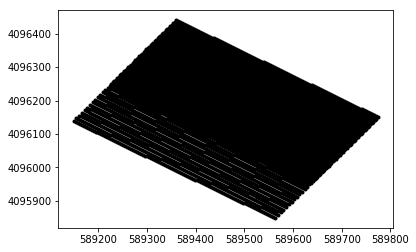

In [17]:
plt.plot(coords['xx'].ravel(), coords['yy'].ravel(), 'k.')

In [22]:
xx = coords['xx']
yy = coords['yy']
x_corners = xx[::xx.shape[0]-1, ::xx.shape[1]-1]
y_corners = yy[::yy.shape[0]-1, ::yy.shape[1]-1]
x_corners, y_corners

(array([[ 589563.42,  589774.19],
        [ 589149.75,  589360.51]]), array([[ 4095849.2,  4096150.2],
        [ 4096138.9,  4096439.9]]))

In [26]:
utm = osgeo.osr.SpatialReference()
wgs84 = osgeo.osr.SpatialReference()
utm.ImportFromEPSG(32629)
wgs84.ImportFromEPSG(4326)
utm2wgs = osgeo.osr.CoordinateTransformation(utm, wgs84)

In [32]:
wgs_corners = utm2wgs.TransformPoints(np.c_[x_corners.ravel(), y_corners.ravel()])

In [40]:
features = []
for corner in wgs_corners:
    pt = geojson.Point(coordinates=[corner[0], corner[1]])
    feature = geojson.Feature(geometry=pt)
    features.append(feature)
collection = geojson.FeatureCollection(features)    

In [43]:
geojson.dump(collection, open('/Users/baart_f/Dropbox/AR_SandBox_Zandmotor/XBeach/FinalModel/bbox.json', 'w'))

In [57]:
%%bash
export MAPBOX_ACCESS_TOKEN=pk.eyJ1Ijoic2lnZ3lmIiwiYSI6Il8xOGdYdlEifQ.3-JZpqwUa3hydjAJFXIlMA
mapbox -v -v -v staticmap --features /Users/baart_f/Dropbox/AR_SandBox_Zandmotor/XBeach/FinalModel/bbox.json --lat 37.0067 --lon -7.9947 --zoom 17 mapbox.satellite --size 1024 1024 test.png

INFO:requests.packages.urllib3.connectionpool:Starting new HTTPS connection (1): api.mapbox.com
DEBUG:requests.packages.urllib3.connectionpool:"GET /v4/mapbox.satellite/geojson(%7B%22features%22%3A%5B%7B%22geometry%22%3A%7B%22coordinates%22%3A%5B-7.993353352801874%2C37.004536544980326%5D%2C%22type%22%3A%22Point%22%7D%2C%22properties%22%3A%7B%7D%2C%22type%22%3A%22Feature%22%7D%2C%7B%22geometry%22%3A%7B%22coordinates%22%3A%5B-7.99094888067895%2C37.00722934975202%5D%2C%22type%22%3A%22Point%22%7D%2C%22properties%22%3A%7B%7D%2C%22type%22%3A%22Feature%22%7D%2C%7B%22geometry%22%3A%7B%22coordinates%22%3A%5B-7.997967868086722%2C37.007186961779084%5D%2C%22type%22%3A%22Point%22%7D%2C%22properties%22%3A%7B%7D%2C%22type%22%3A%22Feature%22%7D%2C%7B%22geometry%22%3A%7B%22coordinates%22%3A%5B-7.995563583308072%2C37.00987986100271%5D%2C%22type%22%3A%22Point%22%7D%2C%22properties%22%3A%7B%7D%2C%22type%22%3A%22Feature%22%7D%5D%2C%22type%22%3A%22FeatureCollection%22%7D)/-7.9947,37.0067,17/1024x1024.png256

In [58]:
!open test.png